In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg19 import VGG19

In [0]:
local_zip = '/gdrive/My Drive/fruits.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/fruits-360_dataset/fruits-360'

train_dir = os.path.join(base_dir, 'Training')
val_dir = os.path.join(base_dir, 'Test')

In [0]:
input_shape = (150, 150, 3)

vgg = VGG19(input_shape = input_shape, weights = 'imagenet', include_top = False)

vgg.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [0]:
for layer in vgg.layers[:-4]:
  layer.trainable = False 

for layer in vgg.layers:
  print(layer, layer.trainable)  

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7feec2078668> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7feec2024550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7feec2024898> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7feec17e5438> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fef23fe1198> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7feeb0581ef0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7feeb0588898> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7feeb0591198> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7feeb05994e0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7feeb05a06a0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7feeb05a85c0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 

In [0]:
model = Sequential()
model.add(vgg)

model.add(Conv2D(256, (3, 3)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(256))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(120, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 256)         1179904   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2, 2, 256)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 2, 256)         1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

In [0]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    vertical_flip = True,
    fill_mode = 'nearest'
)

val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 256,
    class_mode = 'categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (150, 150),
    batch_size = 256,
    class_mode = 'categorical'
) 

Found 60498 images belonging to 120 classes.
Found 20622 images belonging to 120 classes.


In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(),
              metrics = ['accuracy']
              )

In [0]:
filepath = 'model.h5'

checkpoint  = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1)
earlystop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, patience = 3, verbose =1, restore_best_weights = True) 

callback = [earlystop, checkpoint]

history = model.fit_generator(
              train_generator,
              epochs = 15,
              steps_per_epoch = train_generator.samples // train_generator.batch_size,
              validation_data = val_generator,
              validation_steps = val_generator.samples // val_generator.batch_size,
              callbacks = callback,
              verbose = 1,
              shuffle = True
          )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
236/236 [==============================] - ETA: 0s - loss: 2.6059 - accuracy: 0.3739
Epoch 00001: saving model to model.h5
236/236 [==============================] - 419s 2s/step - loss: 2.6059 - accuracy: 0.3739 - val_loss: 2.9007 - val_accuracy: 0.3293
Epoch 2/15
236/236 [==============================] - ETA: 0s - loss: 0.7092 - accuracy: 0.8154
Epoch 00002: saving model to model.h5
236/236 [==============================] - 411s 2s/step - loss: 0.7092 - accuracy: 0.8154 - val_loss: 0.5647 - val_accuracy: 0.8352
Epoch 3/15
236/236 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.9209
Epoch 00003: saving model to model.h5
236/236 [==============================] - 410s 2s/step - loss: 0.3002 - accuracy: 0.9209 - val_loss: 0.4413 - val_accuracy: 0.8613
Epoch 4/15
236/236 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9539
Epoch 00004: saving model to m

<Figure size 432x288 with 0 Axes>

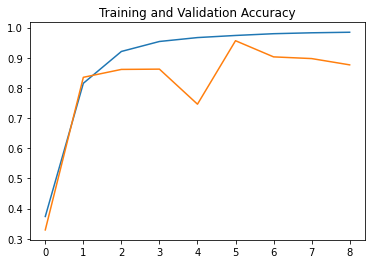

<Figure size 432x288 with 0 Axes>

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and Validation Accuracy')
plt.figure()